# Using Analysis Pipeline to Produce Stellar Spectral Comparison Plots

In `shifting_example_notebook.ipynb` we outlined the process taken to create analysis-ready solar-like UV spectra! But what now? Data analysis of course! In this notebook we will be using Plotly's interactive graphing framework to create some sample analysis one could do to begin gaining intuition for our considered data products. We will be considering the data downloaded in the `data/sunlike_stars` directory, which cites available coadded solar-like spectra from the [Hubble Advanced Spectral Products (HASP)](https://archive.stsci.edu/missions-and-data/hst/hasp) program in the [Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu) in the [E230H grating](https://hst-docs.stsci.edu/stisihb/chapter-13-spectroscopic-reference-material/13-3-gratings/echelle-grating-e230h).

**Note: This notebook uses Plotly interactive graphing to show results. Plotly results are currently unable to be rendered in Github, so [click here](ADD LINK HERE) to view the full notebook and interact with the plots.**

In [1]:
# importing packages and functions
import os
import numpy as np
import pandas as pd
from astropy.table import Table
from astroquery.simbad import Simbad

from spectra_to_rest import *

import chart_studio.plotly as py
import plotly.graph_objects as go
import cufflinks as cf
import seaborn as sns
import plotly.express as px
from matplotlib import cm
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

## Correlating Stellar Parameters with Spectral Features

One of the most interesting things we can consider with the available data is the correlation between spectral parameters (like effective temperature and metallicity) and observed absorption/emission features. To explore this, we can first create a sample of stars by running our `spectra_to_rest` function over all of the stars in the `data/sunlike` directory, and include the ones that produce finite results. We can then query [SIMBAD](https://simbad.cds.unistra.fr/simbad/), an astronomical database that stores available stellar property measurements from literature, for every star in our sample. By formatting this data in an easily accessible table, we allow easy referencing of quantities throughout our analysis.

#### Creating Our Sample Population

In [2]:
sunlike_dir = 'data/sunlike_stars'

star_names = []
star_data = []

# Create loop to reference files for each star
for sdir in os.listdir(sunlike_dir):
    star_dir = os.path.join(sunlike_dir, sdir)
    
    for file in os.listdir(star_dir):
        if file.endswith('.fits'):
            star = os.path.join(star_dir, file)
            result = spectra_to_rest(star)

            # Omit star if it produces a None result
            if any(r is None for r in result):
                continue

            # Append data for sample stars to name and data arrays
            star_rest_wl, star_norm_flux = result
            star_name = star.split('/')[2]
            star_names.append(star_name)
            star_data.append({'star_name': star_name, 'rest_wl': star_rest_wl, 'norm_flux': star_norm_flux})

Cannot cross-correlate data/sunlike_stars/HD147513/hst_12475_stis_hd147513_e230h_obqr_cspec.fits: Error exceeds correlation coefficient!
Cannot normalize data/sunlike_stars/HD157214/hst_8770_stis_hd157214_e230h_o62u_cspec.fits: No points found in flat region 2670–2790 Å for normalization.
Cannot normalize data/sunlike_stars/HD-19445/hst_14672_stis_hd-19445_e230h_od65_cspec.fits: No points found in flat region 2670–2790 Å for normalization.
Cannot normalize data/sunlike_stars/HD4614/hst_8770_stis_hd4614_e230h_o62u_cspec.fits: No points found in flat region 2670–2790 Å for normalization.
Cannot cross-correlate data/sunlike_stars/HD-284248/hst_17184_stis_hd-284248_e230h_oewv_cspec.fits: Error exceeds correlation coefficient!
Cannot cross-correlate data/sunlike_stars/HD1237/hst_12475_stis_hd1237_e230h_obqr_cspec.fits: Error exceeds correlation coefficient!


#### Querying SIMBAD for Stars in Our Sample

In [3]:
# Specify SIMBAD field with teff and metallicity measurements
Simbad.add_votable_fields('mesFe_h')

# Query SIMBAD by star names and store in table
table = Simbad.query_objects(star_names)

# Refine the star table to include requested values
star_table = Table({
    'simbad_id' : table['main_id'],
    'star_id' : table['user_specified_id'],
    '[Fe/H]' : table['mesfe_h.fe_h'],
    'logg' : table['mesfe_h.log_g'],
    'Teff' : table['mesfe_h.teff']
})

# Convert star table to pandas for manipulation
df = star_table.to_pandas()
df_clean = df.replace('--', pd.NA).dropna(subset=['[Fe/H]', 'logg', 'Teff'])   # drop entries without parameter measurements

# Confirm data type of each parameter measurement
df_clean['[Fe/H]'] = df_clean['[Fe/H]'].astype(float)
df_clean['logg'] = df_clean['logg'].astype(float)
df_clean['Teff'] = df_clean['Teff'].astype(float)

# Create summary pandas table of the SIMBAD values
summary_df = df_clean.groupby('star_id').agg({
    '[Fe/H]': ['median', 'std', 'count'],
    'logg': ['median', 'std'],
    'Teff': ['median', 'std']
}).reset_index()

#### Adding Stellar Measurements the `star_data` Array

In [4]:
# Printing the names of stars in each dataframe to check compatibility
unique_star_data_names = set(d['star_name'] for d in star_data)
print("Unique star names in star_data:")
print(sorted(unique_star_data_names), len(unique_star_data_names))

unique_df_names = set(df_clean['star_id'].unique())
print("Unique star names in df_clean:")
print(sorted(unique_df_names), len(unique_df_names))

Unique star names in star_data:
['18-SCO', '47-UMA', 'GJ780', 'GJ9124', 'HD-194598', 'HD-94028', 'HD10647', 'HD114710', 'HD115617', 'HD116956', 'HD1237', 'HD128987', 'HD129333', 'HD1461', 'HD147513', 'HD151541', 'HD154345', 'HD157466', 'HD165185', 'HD166', 'HD190771', 'HD192310', 'HD199288', 'HD20630', 'HD206860', 'HD209458', 'HD28237', 'HD29419', 'HD29980', 'HD33262', 'HD35296', 'HD39587', 'HD43162', 'HD59967', 'HD72905', 'HD73350', 'HD75732', 'HD83443', 'HD90156', 'HD97334'] 40
Unique star names in df_clean:
['GJ780    ', 'GJ9124   ', 'HD10647  ', 'HD114710 ', 'HD115617 ', 'HD116956 ', 'HD1237   ', 'HD128987 ', 'HD129333 ', 'HD1461   ', 'HD147513 ', 'HD151541 ', 'HD154345 ', 'HD157466 ', 'HD165185 ', 'HD166    ', 'HD190771 ', 'HD192310 ', 'HD199288 ', 'HD20630  ', 'HD206860 ', 'HD209458 ', 'HD28237  ', 'HD29419  ', 'HD29980  ', 'HD33262  ', 'HD35296  ', 'HD39587  ', 'HD43162  ', 'HD59967  ', 'HD72905  ', 'HD73350  ', 'HD75732  ', 'HD83443  ', 'HD90156  ', 'HD97334  '] 36


In [5]:
# Write function to change names of stars in df_clean due to different conventions
def name_change(name):
    return name.replace(' ', '').replace('-', '')

# Define indices of wanted parameters
params_dict = summary_df.set_index('star_id')[['Teff', 'logg', '[Fe/H]']].to_dict('index')

# Apply name change to SIMBAD input
changed_params_dict = {
    name_change(k): v for k, v in params_dict.items()
}

# Apply name change to star_data df and add SIMBAD parameters by star name
for star in star_data:
    new_name = name_change(star['star_name'])
    if new_name in changed_params_dict:
        star.update(changed_params_dict[new_name])
    else:
        star.update({'Teff': None, 'logg': None, '[Fe/H]': None})

# Clean up data by filtering out stars that do not have parameter measurements
star_data_clean = [
    star for star in star_data 
    if star.get(('Teff', 'median')) is not None 
    and star.get(('logg', 'median')) is not None 
    and star.get(('[Fe/H]', 'median')) is not None
]

### Exploring Temperature Dependence of Our Sample

Now that we have created the data frame for our stellar sample, we can start creating plots to analyze our data. The first question we can attempt to address is how temperature affects spectral features. Similarly to `shifting_example_notebook.ipynb`, we can reference the Fe I lines in the `lines.csv` file that lists the UV spectral rest lines of elements. Plotting all of the shifted spectra on top of each other, zooming in on visivle Fe I lines, and coloring by temperature will allow us to conclude if there is a correlation between effective temperature and spectral features at these points.

In [6]:
# Defining our lines.csv data and creating a Fe I consideration
lines_csv = 'data/shifting_data/lines.csv'
lines_table = pd.read_csv(lines_csv, sep='\s+', header=None)
lines_table.columns = ['ID', 'Wavelength', 'Elow', 'log(gf)', 'r_log(gf)', 'l_log(eps)(X)', 'log(eps)(X)']   #only really care about first two

fei_rows = lines_table[lines_table['ID'] == 'FeI']
fei_wls = fei_rows['Wavelength']
fei_wls = np.array(fei_wls)

# Filter by Fe I wavelengths visible within spectral coverage, by using lines visible in Alpha Cen basis spectrum
aca_basis = 'data/shifting_data/hst_14788_stis_hd128620_e230h_od5c_cspec.fits'
aca_rest_wls, _ = spectra_to_rest(aca_basis)

visible_idx = (fei_wls >= aca_rest_wls.min())
visible_fei_wls = fei_wls[visible_idx]

In [7]:
# Function to extract stellar parameter from dataframe
def get_star_param(star, param_key):
    """Safely get the parameter from a star, falling back to median if needed."""
    val = star.get(param_key)
    if val is None:
        return star.get((param_key, 'median'))
    return val

# Function to make color map function to be able to color based on parameter
def make_color_scale(values, cmap_name='viridis'):
    """Returns a list of rgba strings normalized from a colormap."""
    norm = plt.Normalize(np.nanmin(values), np.nanmax(values))
    cmap = cm.get_cmap(cmap_name)
    rgba_array = (np.array([cmap(norm(val)) for val in values]) * 255).astype(int)
    return [f'rgba({r},{g},{b},{a/255:.2f})' for r, g, b, a in rgba_array]

In [8]:
# Plotting the first 8 visible Fe I lines

outliers = ['HD35296', 'HD129333', 'HD33262', 'HD29419', 'HD128987', 'GJ9124']   #discovered through previous graphing

param_keys = [('Teff', 'median')]   # can also use ('logg', 'median') and ('[Fe/H]', 'median') as param_keys
param_cmaps = ['plasma', 'hsv_r', 'viridis']

# Loop over each extreme wavelength
for wl_center in visible_fei_wls[0:8]:
    low_wl = wl_center - 0.75
    high_wl = wl_center + 0.75

    # Extract fluxes in window
    for param_key, cmap_name in zip(param_keys, param_cmaps):
        fig = go.Figure()

        # highlight wl_center
        fig.add_vline(
            x=wl_center, 
            line_width=3, 
            line_dash="dash", 
            line_color="black",
            name = f'FeI rest line: {wl_center} Å'
        )

        # Prepare color mapping
        param_values = []
        valid_stars = []
        
        for star in star_data_clean:
            if star['star_name'] not in outliers:
                val = get_star_param(star, param_key)
                if val is not None:
                    param_values.append(val)
                    valid_stars.append(star)
        
        param_values = np.array(param_values)
        colors = make_color_scale(param_values, cmap_name=cmap_name)
        
        # Now loop over only valid stars
        for star, color, val in zip(valid_stars, colors, param_values):
            rest_wl = star['rest_wl']
            flux = star['norm_flux']
            mask = (rest_wl >= low_wl) & (rest_wl <= high_wl)

            
            if np.sum(mask) == 0:
                continue
        
            fig.add_trace(go.Scatter(
                x=rest_wl[mask],
                y=flux[mask],
                mode='lines',
                line=dict(color=color, width=1),
                name=star['star_name'],
                hovertemplate=f"{star['star_name']}<br>{param_key}: {val}<extra></extra>",
            ))

        # dummy scatter for colorbar legend
        fig.add_trace(go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(
                colorscale=cmap_name,
                colorbar=dict(title=param_key[0]),
                showscale=True,
                cmin=np.min(param_values),
                cmax=np.max(param_values),
                color=np.mean(param_values)  # dummy scalar
            ),
            hoverinfo='none',
            showlegend=False
        ))

        fig.update_layout(
            title=f"{param_key[0]}-Colored Spectra for Fe I line at {wl_center} Å",
            xaxis_title='Wavelength (Å)',
            yaxis_title='Normalized Flux',
            height=500,
            width=900,
            template='plotly_white',
            showlegend=False
            #coloraxis_colorbar=dict(title=param_key[0])
        )

        fig.show()

/var/folders/t6/smgsly8n5hs1561d_9m2zw6r00061n/T/ipykernel_56429/4044870724.py:13: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [9]:
print(f"{len(valid_stars)} stars plotted with param_key = {param_key}")

30 stars plotted with param_key = ('Teff', 'median')


Wow, we can really see a clear temperature dependence in these stars! It seems that at these lines higher temperatures correlate to shallower features. But what about stellar metallicities, or [Fe/H]? Due to the severity of the temperature dependence, and the idea that we expect temperature to have the largest affect on feature prominence, to truly consider the effects of metallcity on stellar features we should create a smaller sample of thermally-similar stars. Out of the 30 stars we are considering, we can create a histogram of their effective temperatures and find the most populated region of which to derive our sample.

In [10]:
teff_vals = [star.get(('Teff', 'median')) for star in star_data_clean]
teff_vals = np.array(teff_vals)

fig = px.histogram(star_data_clean, x=teff_vals, nbins=20, labels={'x' : 'Teff'}, title='Effective Temperature Counts for Sun-Like Stars')
fig.show()

From the histogram it appears that we have the most solar-like stars (7) within a temperature range of 5800-5900. Zooming in on that region, we can then plot the spectra over one another, and colored by their [Fe/H] measurements to directly compare metallicity effects.

In [11]:
# Define our temperature mask
teff_mask = (teff_vals >= 5800) & (teff_vals < 5900)
teff_stars = [star for star, keep in zip(valid_stars, teff_mask) if keep]
len(teff_stars)

7

In [12]:
# Plotting the first 8 Fe I windows by metallicity for temperature consistent range

param_keys = [('[Fe/H]', 'median')]
param_cmaps = ['viridis']

# Loop over each Fe I wavelength
for wl_center in visible_fei_wls[0:8]:
    low_wl = wl_center - 0.75
    high_wl = wl_center + 0.75

    # Looping over metallicity (could add more parameters to consider if desired in param_keys/cmaps)
    for param_key, cmap_name in zip(param_keys, param_cmaps):
        fig = go.Figure()

        # Emphasizing Fe I line
        fig.add_vline(
            x=wl_center, 
            line_width=3, 
            line_dash="dash", 
            line_color="black",
            name = f'FeI rest line: {wl_center} Å'
        )

        param_values = []
        valid_stars = []

        # Loop over all stars in our temperature sample
        for star in teff_stars:
            val = get_star_param(star, param_key)
            if val is not None:
                param_values.append(val)
                valid_stars.append(star)
        
        param_values = np.array(param_values)
        colors = make_color_scale(param_values, cmap_name=cmap_name)
        
        # Now loop over only stars with physical values
        for star, color, val in zip(valid_stars, colors, param_values):
            rest_wl = star['rest_wl']
            flux = star['norm_flux']
            mask = (rest_wl >= low_wl) & (rest_wl <= high_wl)
        
            fig.add_trace(go.Scatter(
                x=rest_wl[mask],
                y=flux[mask],
                mode='lines',
                line=dict(color=color, width=1),
                name=star['star_name'],
                hovertemplate=f"{star['star_name']}<br>{param_key}: {val}<extra></extra>",
            ))

        # dummy scatter for colorbar legend
        fig.add_trace(go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(
                colorscale=cmap_name,
                colorbar=dict(title=param_key[0]),
                showscale=True,
                cmin=np.min(param_values),
                cmax=np.max(param_values),
                color=np.mean(param_values)  # dummy scalar
            ),
            hoverinfo='none',
            showlegend=False
        ))

        fig.update_layout(
            title=f"{param_key[0]}-Colored Spectra for Fe I line at {wl_center} Å",
            xaxis_title='Wavelength (Å)',
            yaxis_title='Normalized Flux',
            height=500,
            width=900,
            template='plotly_white',
            showlegend=False
            #coloraxis_colorbar=dict(title=param_key[0])
        )

        fig.show()

/var/folders/t6/smgsly8n5hs1561d_9m2zw6r00061n/T/ipykernel_56429/4044870724.py:13: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Looking at these plots, it appears that there is some metallicity dependence, where higher [Fe/H] values correspond to deeper features. This is expected behavior, as we are looking at Fe I lines, so we predict more Fe I absorbance in stars with higher Fe concentrations. However, it is not immediately clear if the sample is acting as expected. Let's create flux vs. [Fe/H] plots and calculate a trend line to see the actual correspondance.

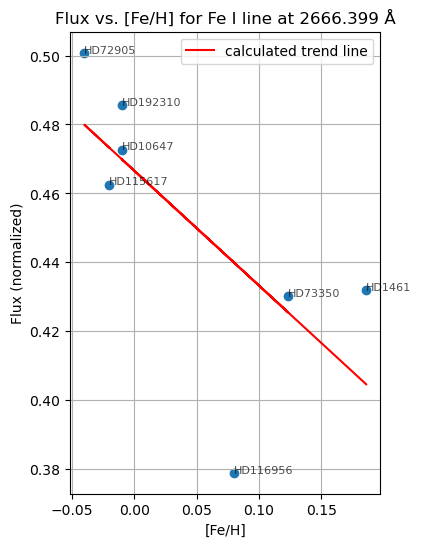

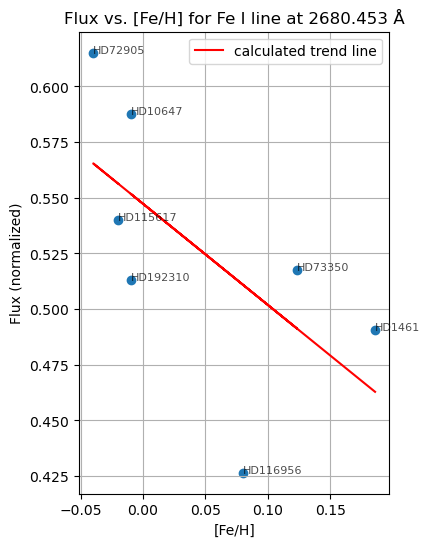

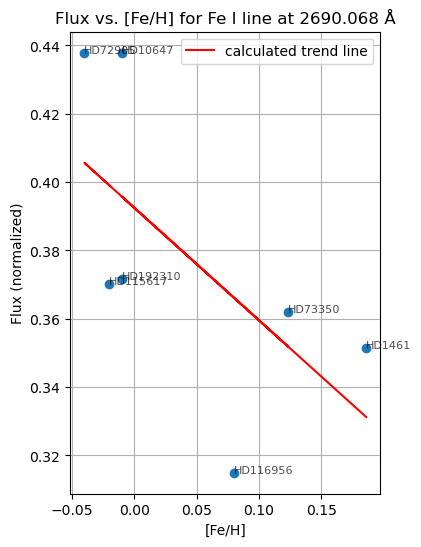

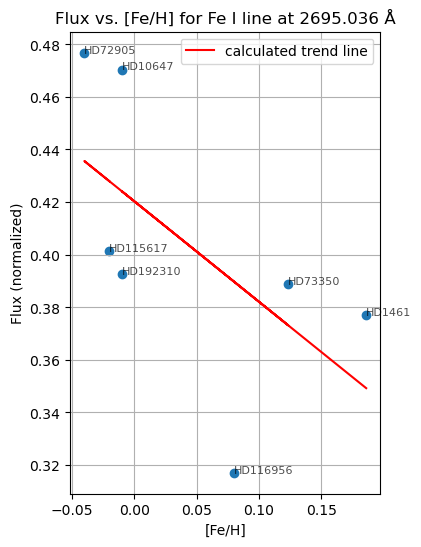

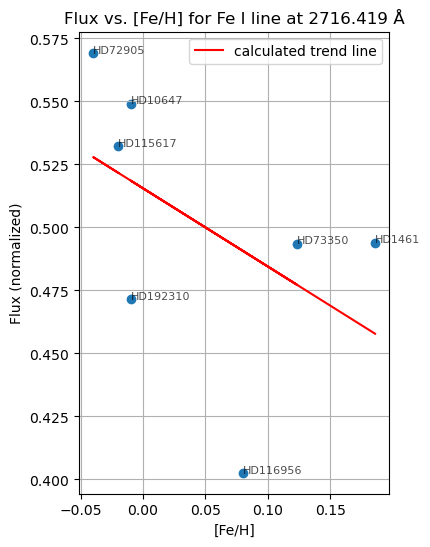

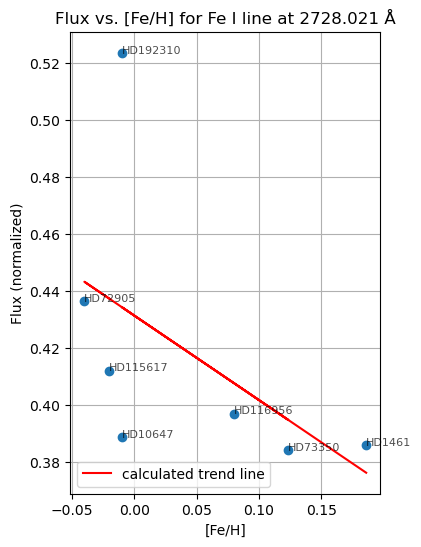

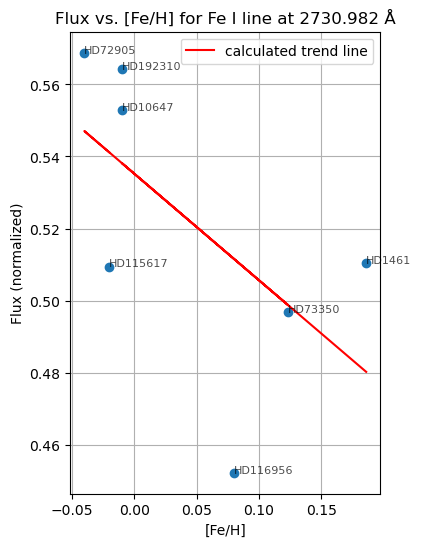

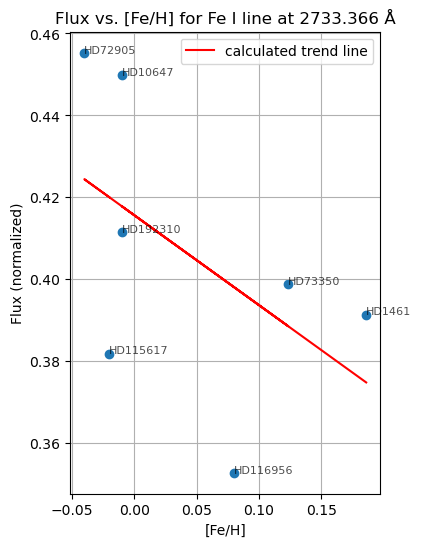

In [13]:
#plot metal vs flux for similar temp stars sample

outliers = ['HD35296', 'HD129333', 'HD33262', 'HD29419', 'HD128987', 'GJ9124']

for idx, fei_line in enumerate(visible_fei_wls[0:8]):
    low_wl = fei_line - 1
    high_wl = fei_line + 1
    
    feh_vals = []
    flux_vals = []
    star_names = []
    fit_flux_vals = []
    fit_feh_vals = []
    
    for star in teff_stars:
        if star['star_name'] not in outliers:
            wl = star['rest_wl']
            wl_mask = (wl >=low_wl) & (wl <= high_wl)
            flux = star['norm_flux']
            
            flux_val = np.mean(flux[wl_mask])
            feh_val = get_star_param(star, ('[Fe/H]', 'median'))

            flux_vals.append(flux_val)
            feh_vals.append(feh_val)
            star_names.append(star['star_name'])

            fit_flux_vals.append(flux_val)
            fit_feh_vals.append(feh_val)

    fit_feh_vals = np.array(fit_feh_vals)
    fit_flux_vals = np.array(fit_flux_vals)
    m, b = np.polyfit(fit_feh_vals, fit_flux_vals, 1)
    
    plt.figure(figsize=(4,6))
    
    plt.title(f'Flux vs. [Fe/H] for Fe I line at {fei_line:.3f} Å')
    plt.scatter(feh_vals, flux_vals)
    feh_vals_np = np.array(feh_vals)
    plt.plot(fit_feh_vals, m * fit_feh_vals + b, color='red', label='calculated trend line')
    plt.xlabel('[Fe/H]')
    plt.ylabel('Flux (normalized)')
    plt.grid()
    for x, y, name in zip(feh_vals, flux_vals, star_names):
        plt.text(x, y, name, fontsize=8, alpha=0.7)
    plt.legend()
    plt.show()

While these plots may not be as clear as we want them to be yet, we see a clear metallicity dependence where higher Fe/H concentrations correlate to deeper features. Now that we know these effects are measureable we can begin looking into heavier elements and quantifying chemical abundances across the Sun-like sample range!